# FX vol trading strategy - implementation

In [11]:
# Import libraries
import pandas as pd
import numpy as np
from data_cleaning.import_data import import_data
from utils.garch import get_rolling_vol_forecasts
from utils.plots import plot_trades, plot_grid_forecasted_vs_realized
from utils.statistics import forecasting_accuracy
from utils.trading_strategy import gen_trading_signals, calc_pnl
from arch import arch_model

import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
fx_pairs =[
    'USDRUB',
    'USDZAR',
    'USDBRL',
    'EURUSD',
    'USDJPY',
    'GBPUSD'
]
dfs = { pair : import_data(fx_pair=pair) for pair in fx_pairs }

AttributeError: 'DataFrame' object has no attribute 'px_last'

## Forecast volatility

In [3]:
# generate volatility forecasts
for pair, df in dfs.items():
    return_series = dfs[pair].dropna()['log_ret'] * 100 
    model = arch_model(return_series, vol='GARCH', p=1, q=1, dist='Studentst')  # every pair gets a GARCH(1,1) cf. Lunde
    
    # Conditional volatility forecasting
    vol_forecasts = get_rolling_vol_forecasts(return_series=return_series,
                                                model = model, 
                                                horizon=21,
                                                fitting_end_date="2021-01-01",
                                                ) # rolling forecast to get sequential 21-days-ahead conditional volatility forecasts
    dfs[pair] = dfs[pair].merge(vol_forecasts['h.21'], left_index=True, right_index=True)
    dfs[pair].rename(columns={'h.21':'cond_vol_forecast'},inplace=True)
    dfs[pair]['cond_forecast_to_implied'] = dfs[pair]['cond_vol_forecast'] / dfs[pair]['v1m']



Fitting rolling GARCH(p: 1, q: 1) model with a Standardized Student's t distribution.
Number of forecasts: 277
.....................................................................................................................................................................................................................................................................................
Fitting rolling GARCH(p: 1, q: 1) model with a Standardized Student's t distribution.
Number of forecasts: 277
.....................................................................................................................................................................................................................................................................................
Fitting rolling GARCH(p: 1, q: 1) model with a Standardized Student's t distribution.
Number of forecasts: 277
..............................................................................................................

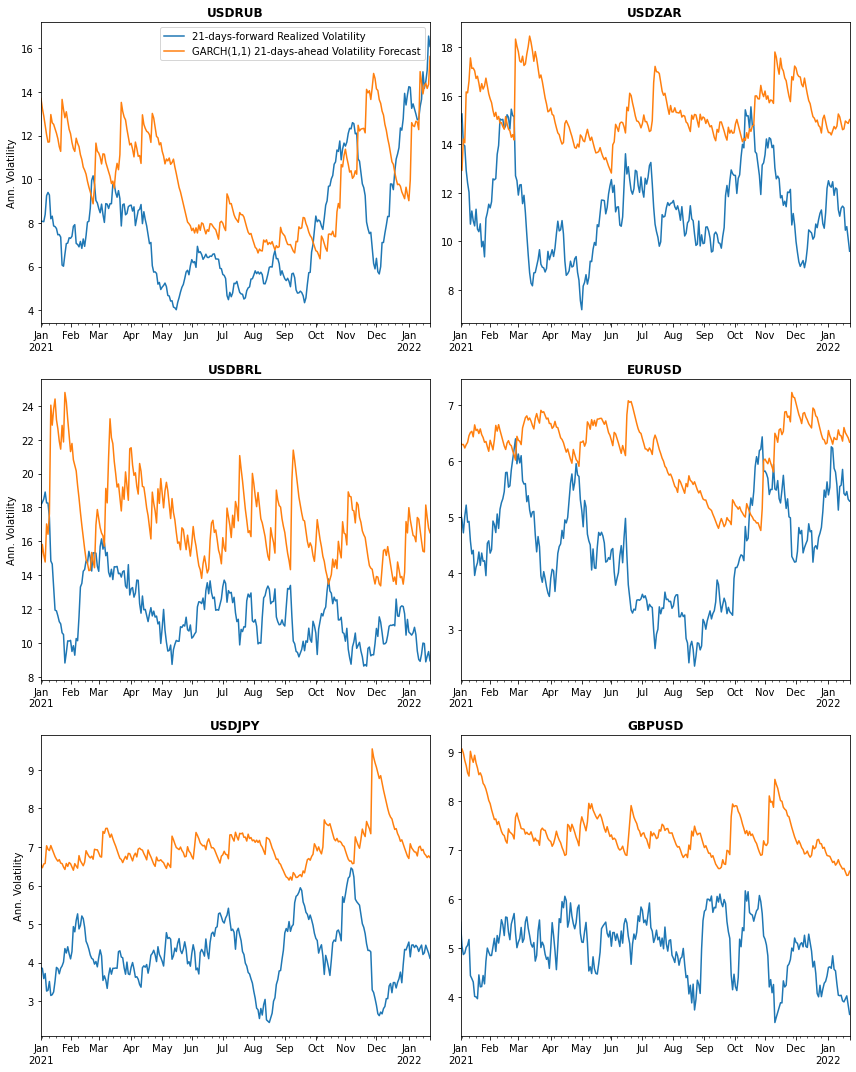

In [4]:
plot_grid_forecasted_vs_realized(df_dict=dfs, implied=False)

## Generate trading signals

We start by looking at 1 pair, e.g. USDRUB.

We can either hold to maturity (``days_holding_period`` $=21$) and get: 
$$ PnL = sign(direction) * (realized^{\ next \ 21 \ days} - implied^{\ now}) - 2 * spread $$

or we can close trade by going opposite direction after ``days_holding_period``$ = 0<x<21$ days and get:
$$ PnL = sign(direction) * (implied^{\ in \ x \ days} - implied^{\ now}) - 2 * spread $$


In [5]:
threshold_up = 1.3
threshold_down = 0.7
days_holding_period = 5 # 21
pair = 'USDZAR'
df = dfs[pair].copy(deep=True)

In [6]:
gen_trading_signals(df, thres_up=threshold_up,thres_down=threshold_down, days_holding_period = days_holding_period)
df.tail(10)

,v1m,v3m,v1y,px_last,px_bid,px_ask,log_ret,rolling_21d_realized_stdev,forward_rolling_21d_realized_stdev,normalized_bid_ask_spread,cond_vol_forecast,cond_forecast_to_implied,direction,gearing,v1m_close_trade,returns,returns_w_gearing,direction_flag
2022-01-11,15.0750,15.1025,15.5550,15.5250,15.5115,15.5384,-0.009654,9.709140,12.152543,0.173269,14.749100,0.978381,0,0.0,15.135,-0.346539,-0.346539,nan
2022-01-12,14.8900,15.0725,15.5150,15.3084,15.2933,15.3235,-0.014050,10.468926,11.302449,0.197277,15.248341,1.024066,0,0.0,14.980,-0.394555,-0.394555,nan
2022-01-13,14.8775,15.1600,15.5150,15.4053,15.3907,15.4200,0.006310,10.405933,11.034463,0.190194,15.126590,1.016743,0,0.0,14.575,-0.380387,-0.380387,nan
2022-01-14,14.8625,15.1675,15.5200,15.3899,15.3356,15.4443,-0.001000,10.344635,11.361947,0.706305,14.853194,0.999374,0,0.0,14.960,-1.412610,-1.412610,nan
2022-01-17,15.0250,15.0600,15.4800,15.3855,15.3752,15.3959,-0.000286,10.087891,11.451322,0.134542,14.600459,0.971744,0,0.0,15.960,-0.269084,-0.269084,nan
2022-01-18,15.1350,15.1450,15.6050,15.5209,15.5005,15.5413,0.008762,10.189944,11.377639,0.262871,14.633883,0.966890,0,0.0,NaN,NaN,NaN,nan
2022-01-19,14.9800,15.1050,15.5850,15.3320,15.3181,15.3460,-0.012245,10.712999,10.458027,0.181972,14.959170,0.998609,0,0.0,NaN,NaN,NaN,nan
2022-01-20,14.5750,15.1450,15.5650,15.2181,15.2092,15.2270,-0.007457,10.562268,10.605442,0.116966,14.904936,1.022637,0,0.0,NaN,NaN,NaN,nan
2022-01-21,14.9600,15.2750,15.6175,15.1042,15.0891,15.1193,-0.007513,10.894393,10.115416,0.199944,14.858638,0.993224,0,0.0,NaN,NaN,NaN,nan
2022-01-24,15.9600,15.7250,15.7900,15.2614,15.2471,15.2757,0.010354,11.152745,9.589261,0.187401,15.017679,0.940957,0,0.0,NaN,NaN,NaN,nan


## How does the trades look?

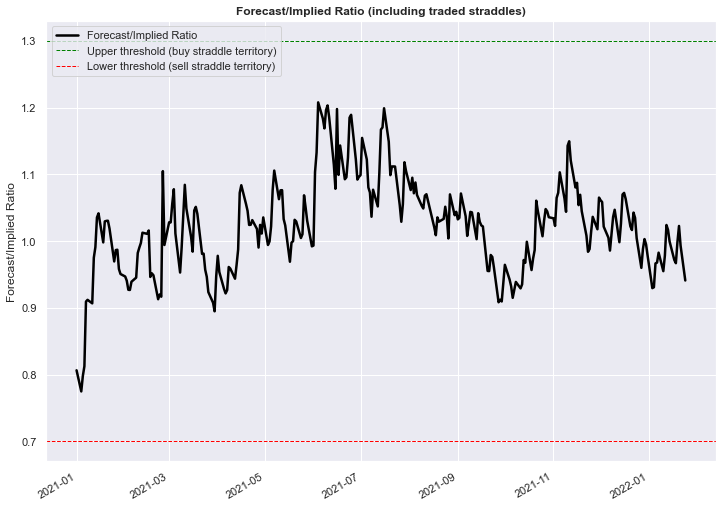

In [7]:
plot_trades(df=df,
            thres_up=threshold_up,
            thres_down=threshold_down, 
            #include_implied=True, 
            #include_forecasted=True,
            )

As can be seen from the graph, we are short vol the whole period due to the thresholds....

Number of trades:  0
Normalized PnL: 0.00%
Normalized PnL w. Gearing: 0.00%


/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:518: UserWarning: Attempting to set identical left == right == 18627.0 results in singular transformations; automatically expanding.
  ax.set_xlim(self.xlim)


,direction,v1m,v1m_close_trade,forward_rolling_21d_realized_stdev,normalized_bid_ask_spread,gearing,returns,returns_w_gearing,normalized_pnl,normalized_pnl_w_gearing
2020-12-31,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


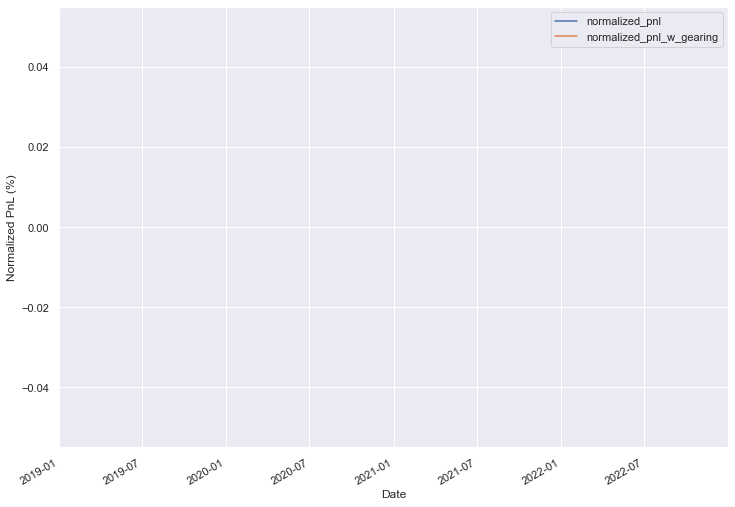

In [8]:
calc_pnl(df,plot=True)

### Overview (trying different strategies)

In [9]:
threshold_up = [1.05, 1.1, 1.2, 1.3]
threshold_down = [0.95, 0.9, 0.8, 0.7]
days_holding_period = 21

In [10]:
for pair in dfs.keys():
    print(pair)
    df = dfs[pair].copy(deep=True)

    for up, down in zip(threshold_up, threshold_down):
        print(f"{up}/{down}")
        gen_trading_signals(df, thres_up=up,thres_down=down, days_holding_period = days_holding_period)
        calc_pnl(df,plot=False, return_df=False)
        print('--------------\n')

USDRUB
1.05/0.95
Number of trades:  13
Normalized PnL: 83.96%
Normalized PnL w. Gearing: 106.73%
--------------

1.1/0.9
Number of trades:  13
Normalized PnL: 87.39%
Normalized PnL w. Gearing: 110.64%
--------------

1.2/0.8
Number of trades:  11
Normalized PnL: 71.07%
Normalized PnL w. Gearing: 89.96%
--------------

1.3/0.7
Number of trades:  4
Normalized PnL: 10.97%
Normalized PnL w. Gearing: 13.91%
--------------

USDZAR
1.05/0.95
Number of trades:  12
Normalized PnL: -4.25%
Normalized PnL w. Gearing: -4.24%
--------------

1.1/0.9
Number of trades:  7
Normalized PnL: -9.50%
Normalized PnL w. Gearing: -9.96%
--------------

1.2/0.8
Number of trades:  2
Normalized PnL: -0.74%
Normalized PnL w. Gearing: -0.66%
--------------

1.3/0.7
Number of trades:  0
Normalized PnL: 0.00%
Normalized PnL w. Gearing: 0.00%
--------------

USDBRL
1.05/0.95
Number of trades:  13
Normalized PnL: -15.13%
Normalized PnL w. Gearing: -15.81%
--------------

1.1/0.9
Number of trades:  10
Normalized PnL: 16